In [1]:
%%sh
python3 --version

Python 3.10.12


In [5]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette('rainbow')
sns.set_context('talk')

new_basedir = '/home/jack/Documents/kona_coffee/'

df = pd.read_csv('/home/jack/Documents/classified_masks.csv')

df['image'] = df['image'].apply(lambda x: os.path.join(new_basedir, os.path.basename(x)))

df

,image,lifecycle
0,/home/jack/Documents/kona_coffee/100_0045_0_24...,ripening
1,/home/jack/Documents/kona_coffee/100_0060_3200...,ripe
2,/home/jack/Documents/kona_coffee/100_0060_3200...,ripening
3,/home/jack/Documents/kona_coffee/100_0060_3200...,unripe
4,/home/jack/Documents/kona_coffee/100_0060_3200...,unripe
...,...,...
1123,/home/jack/Documents/kona_coffee/100_0012_2400...,unripe
1124,/home/jack/Documents/kona_coffee/100_0012_2400...,unripe
1125,/home/jack/Documents/kona_coffee/100_0012_2400...,unripe
1126,/home/jack/Documents/kona_coffee/100_0012_2400...,ripe


In [6]:
df['lifecycle'].value_counts()

unripe      659
ripe        276
ripening    193
Name: lifecycle, dtype: int64

In [11]:
# sample training data
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

In [25]:
# load resnet50v2 model trained on imagenet dataset
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in resnet.layers:
    layer.trainable = False
    
outputs = resnet.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(256, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = keras.Model(inputs=resnet.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

In [26]:
# image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(image):
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    return image

datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    zoom_range=0.0,
    shear_range=0.0,
    brightness_range=[0.0, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = datagen.flow_from_dataframe(
    df_train,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    validation_split=0.2,
    seed=42,
    batch_size=32,
    shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    seed=42,
    batch_size=1,
    shuffle=False
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=1
)

Found 902 validated image filenames belonging to 3 classes.
Found 226 validated image filenames belonging to 3 classes.


Epoch 1/300


2023-11-16 20:10:08.104617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.5909 - auc: 0.7423 - precision: 0.6223 - recall: 0.5022

2023-11-16 20:10:19.016124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 19s 516ms/step - loss: 1.0610 - accuracy: 0.5909 - auc: 0.7423 - precision: 0.6223 - recall: 0.5022 - val_loss: 0.8948 - val_accuracy: 0.5909 - val_auc: 0.7689 - val_precision: 0.6645 - val_recall: 0.4435
Epoch 2/300
29/29 [==============================] - 14s 478ms/step - loss: 0.8951 - accuracy: 0.6098 - auc: 0.7788 - precision: 0.6566 - recall: 0.5044 - val_loss: 1.0348 - val_accuracy: 0.5787 - val_auc: 0.7670 - val_precision: 0.5947 - val_recall: 0.5676
Epoch 3/300
29/29 [==============================] - 14s 481ms/step - loss: 0.9077 - accuracy: 0.5865 - auc: 0.7744 - precision: 0.6408 - recall: 0.5044 - val_loss: 0.8020 - val_accuracy: 0.6707 - val_auc: 0.8251 - val_precision: 0.7397 - val_recall: 0.5166
Epoch 4/300
29/29 [==============================] - 14s 480ms/step - loss: 0.8330 - accuracy: 0.6386 - auc: 0.8108 - precision: 0.7092 - recall: 0.5299 - val_loss: 0.8160 - val_accuracy: 0.6652 - val_auc: 0.8210 - val_precision: 0.7352 -

10


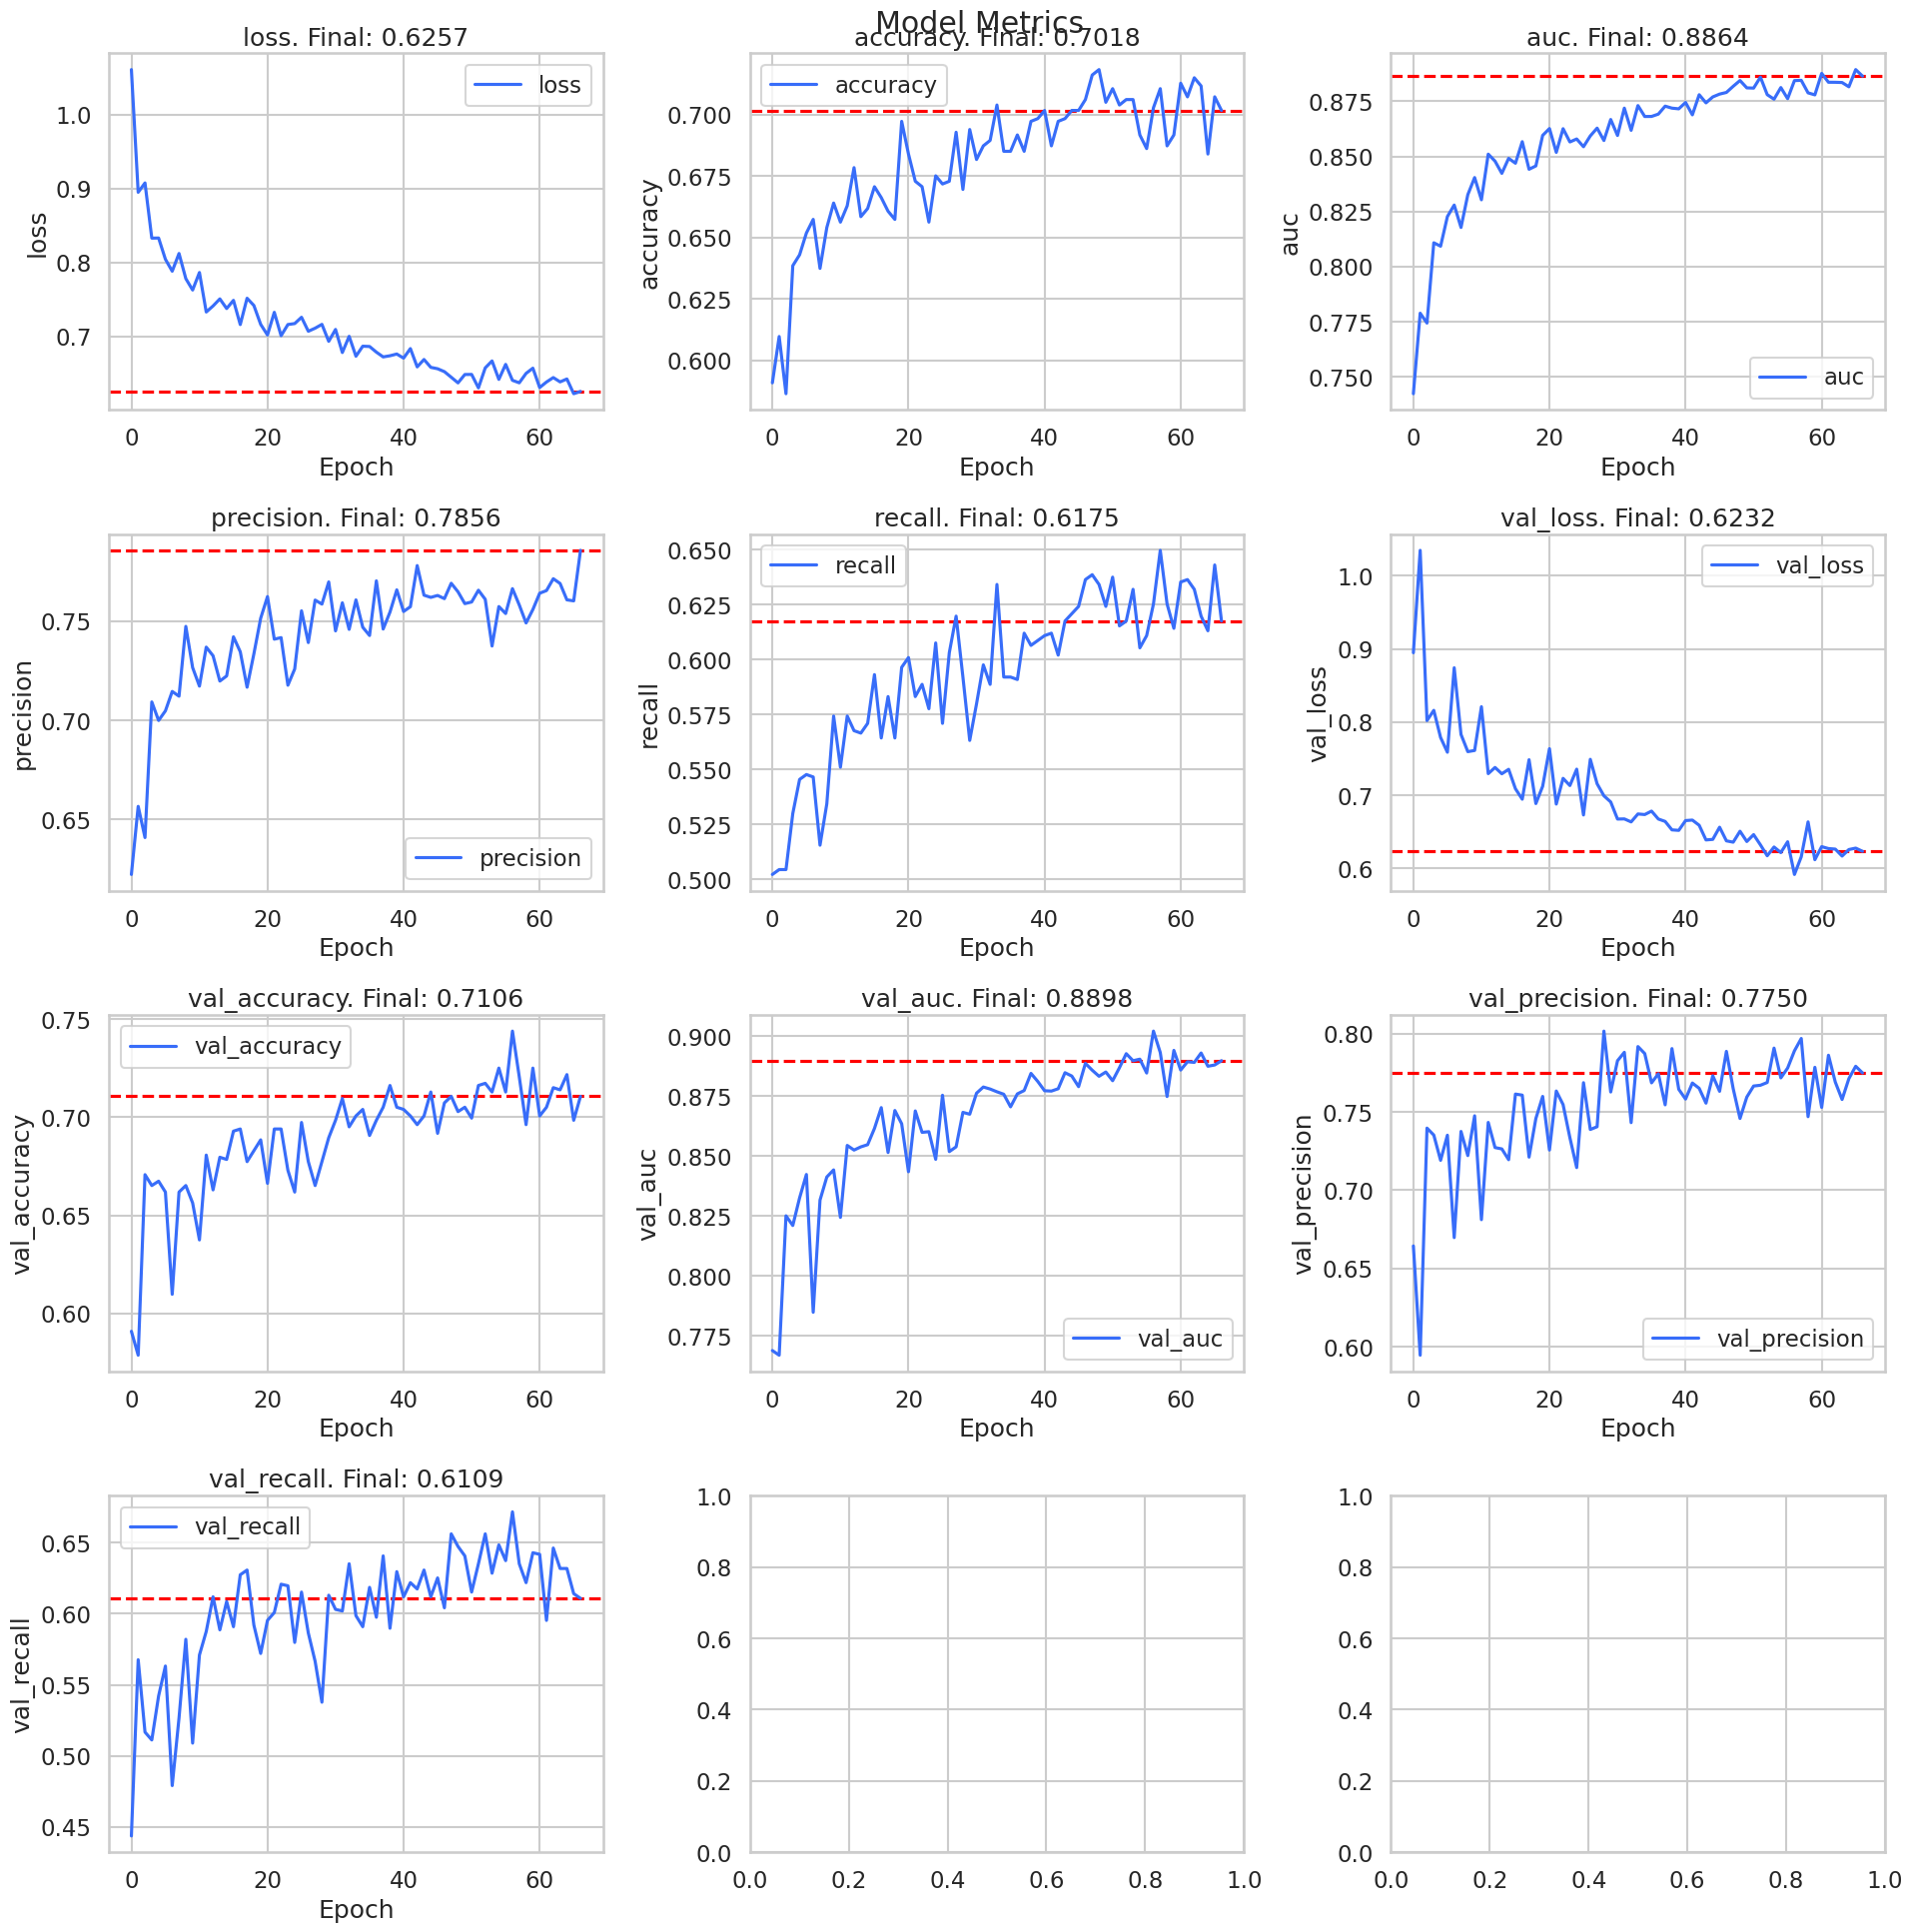

In [34]:
import matplotlib.pyplot as plt

metrics = history.history.keys()

print(len(metrics))

cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

# pad the axes
fig.tight_layout(pad=3.0)

fig.suptitle('Model Metrics')

keys = history.history.keys()

for i, key in enumerate(keys):
    
    final_val = history.history[key][-1]
    
    axes[i].axhline(final_val, ls='--', color='r')
    axes[i].plot(history.history[key], label=key)
    axes[i].set_title(f'{key}. Final: {final_val:.4f}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(key)
    axes[i].legend()


In [ ]:
test = model.evaluate(test_gen, verbose=1)

print(f'Test loss: {test[0]}')
print(f'Test accuracy: {test[1]}')
print(f'Test AUC: {test[2]}')
print(f'Test Precision: {test[3]}')
print(f'Test Recall: {test[4]}')